In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import statistics
import os
import time

In [2]:
# This function will read in an image and then convert it into a 500x500 pixel image
def read_img(name):
    img = cv2.imread(name, 0)
    width = 500 # new width
    height = 500 # new height
    dim = (width, height) # new dimension tuple
    resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA) # set new dimensions
    return resized # return 500x500 pixel image

In [3]:
# This function circles all the individual cells in the image leaving area's without any cells black
def show_edges(img, mi, ma):
    edges = cv2.Canny(img, mi, ma)
    return edges

In [4]:
# This will change the highlighted white circles into a uniform white space, leaving only the wound area as black
# default threshold: 100
# default radius: 250
def change_intensity(img, threshold, radius):
    imgBW = img
    h = imgBW.shape[0] # collect height of input image
    w = imgBW.shape[1] # collect width of input image
    center_x = int(h / 2) # x-coordinate of image center
    center_y = int(h / 2) # y-coordinate of image center
    rows = [] # empty array that will hold a value for each row of the image
    for y in range(0, h): # iterate of each row of pixels in image
        numNotBlack = 0 # counter to see how many pixels are white
        for x in range(0, w): # iterate over each pixel in a row
            # the following two lines make sure that program only looks at a circle of radius 250 pixels 
            # this is because the corners of the image are not of interest
            dist = math.hypot(center_x - x, center_y - y)
            imgBW[y, x] = 255 if (dist > radius) else imgBW[y, x]
            # increment counter as needed 
            numNotBlack = numNotBlack + 1 if (imgBW[y, x] != 0) else numNotBlack
        rows.append(numNotBlack) # add number of non-black pixels to row array
    average_not_black = int(sum(rows) / len(rows))
    index = 0
    for row in rows:
        # If a row contains more white than the adjusted average amount of white pixels, convert it entirely to white
        if row > (average_not_black - threshold):
            for x in range(0, w):
                imgBW[index, x] = 255
        index += 1

    return imgBW

In [5]:
# Changes the color of black pixels to blue to make the wound area more visible
def change_color_blue(img, original):
    count = 0
    imgRGB = cv2.GaussianBlur(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB), (5, 5), 0)
    original = cv2.cvtColor(original, cv2.COLOR_GRAY2RGB)
    h = imgRGB.shape[0]
    w = imgRGB.shape[1]

    for y in range(0, h):
        for x in range(0, w):
            if imgRGB[y, x][0] < 60 and imgRGB[y, x][1] < 60 and imgRGB[y, x][2] < 60:
                imgRGB[y, x] = (0, 0, 255)
                if original[y, x][0] < 100 and original[y, x][1] < 100 and original[y, x][2] < 100:
                    original[y, x] = (0, 0, 255) # change the wound pixel in the original to blue
                count += 1 # increment count of pixels
    return original, count

In [6]:
# shows comparison of original image to image with wound highlighted
def show_comparison(img, img2, name):
    plt.subplot(121), plt.imshow(img, cmap='gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(img2, cmap='gray')
    plt.title('Wound-Only Image'), plt.xticks([]), plt.yticks([])
    size = len(name)
    mod_name = name[:size - 4]

    plt.savefig('Final_Images/' + mod_name + '.png')
    plt.show()
    plt.close()

In [10]:
# Create output CSV file that will show image filenames and the size of their wounds
timestr = time.strftime("%m%d%Y-%H%M%S")
outName = timestr + "_output.csv"
output = open(outName, "x")
output.write("Image,Wound Area\n")

17

In [11]:
for filename in os.listdir("Wound_Images/"):
    if filename.endswith('F'):
        imagePath = "Wound_Images/" + filename
        image = read_img(imagePath)
        edges = show_edges(image, 5, 30)
        imgBW = change_intensity(edges, 100, 250)
        blue, pixels = change_color_blue(imgBW, image)
#         show_comparison(image, blue, filename)
        output.write(filename + "," + str(pixels) + "\n")
        cv2.imwrite('Final_Images/' + filename + 'FINAL.png', blue)
        print("Number of wound pixels for ", filename, ": ", pixels)
output.close()

Number of wound pixels for  DTG Haloparidol 5fold  02232021_A06 (2).TIF :  7453
Number of wound pixels for  DTG Haloparidol 5fold  02232021_A03 (1).TIF :  27428
Number of wound pixels for  DTG Haloparidol 5fold  02232021_A02 (1).TIF :  31973
Number of wound pixels for  DTG Haloparidol 5fold  02232021_A05 (2).TIF :  13696
Number of wound pixels for  DTG Haloparidol 5fold  02232021_A04 (2).TIF :  7048
Number of wound pixels for  DTG Haloparidol 5fold  02232021_A04 (1).TIF :  23740
Number of wound pixels for  DTG Haloparidol 5fold  02232021_A05 (1).TIF :  31196
Number of wound pixels for  DTG Haloparidol 5fold  02232021_A02 (2).TIF :  16622
Number of wound pixels for  DTG Haloparidol 5fold  02232021_A06 (1).TIF :  27434
Number of wound pixels for  DTG Haloparidol 5fold  02232021_A03 (2).TIF :  12305


In [12]:
def jaccard_index(annotated, img, mi, ma, threshold, radius):
    programImg = read_img(img)
    anoImg = read_img(annotated)
    edges = show_edges(programImg, mi, ma)
    imgBW = change_intensity(edges, threshold, radius)
    h = imgBW.shape[0]
    w = imgBW.shape[1]
    AnoImgPix = []
    ImgPix = []
    for y in range(0, h):
        for x in range(0, w):
            if anoImg[y, x] > 225 and anoImg[y, x] > 225 and anoImg[y, x] > 225:
                 AnoImgPix.append((y,x))
            if imgBW[y, x] < 60 and imgBW[y, x] < 60 and imgBW[y, x] < 60:
                 ImgPix.append((y,x))
    union_list = list(set(AnoImgPix) | set(ImgPix))
    intersection_list = [value for value in AnoImgPix if value in ImgPix]
    return (len(intersection_list)/len(union_list))

In [14]:
jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A02 (1).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A02 (1).TIF', 10, 15, 110, 250)

0.8004930582587259

In [15]:
jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A03 (1).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A03 (1).TIF', 10, 15, 110, 250)

0.8327145214521452

In [17]:
jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A04 (1).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A04 (1).TIF', 10, 15, 110, 250)

0.8083073386964373

In [18]:
jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A05 (1).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A05 (1).TIF', 10, 15, 110, 250)

0.8779102478231748

In [19]:
jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A06 (1).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A06 (1).TIF', 10, 15, 110, 250)

0.8227552790572471

In [20]:
jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A02 (2).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A02 (2).TIF', 10, 15,110, 250)

0.5456731860053546

In [21]:
jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A03 (2).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A03 (2).TIF', 10, 15,110, 250)

0.5577060931899641

In [22]:
jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A04 (2).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A04 (2).TIF', 10, 15,110, 250)

0.4353030430751075

In [23]:
jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A05 (2).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A05 (2).TIF', 10, 15, 110, 250)

0.7194656488549618

In [24]:
jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A06 (2).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A06 (2).TIF', 10, 15, 110, 250)

0.46073805984618366

In [26]:
img = read_img('Wound_Images/DTG Haloparidol 5fold  02232021_A04 (1).TIF')

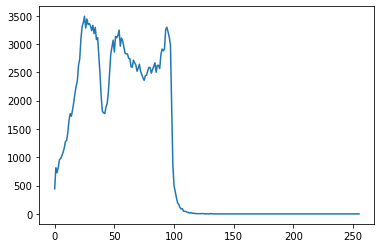

In [27]:
histg = cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(histg)
plt.show()

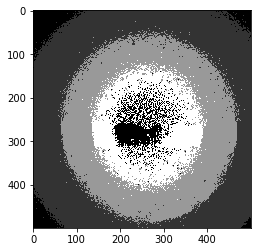

In [40]:
img = read_img('Wound_Images/DTG Haloparidol 5fold  02232021_A04 (1).TIF')
h = img.shape[0] # collect height of input image
w = img.shape[1] # collect width of input image
center_x = int(h / 2) # x-coordinate of image center
center_y = int(h / 2) # y-coordinate of image center
rows = [] # empty array that will hold a value for each row of the image
for y in range(0, h): # iterate of each row of pixels in image
    for x in range(0, w): # iterate over each pixel in a row
        if img[y,x] > 10 and img[y,x] <= 50:
            img[y,x] = 50
        elif img[y,x] > 50 and img[y,x] <= 80:
            img[y,x] = 150
        elif img[y,x] > 80 and img[y,x] <= 95:
            img[y,x] = 250
        else:
            img[y,x] = 0
cv2.imwrite('Final_Images/gradient.png', img)
plt.imshow(img, cmap="gray")



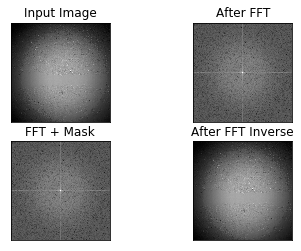

In [31]:
img = cv2.imread('Wound_Images/DTG Haloparidol 5fold  02232021_A04 (1).TIF', 0)
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
rows, cols = img.shape
crow, ccol = int(rows / 2), int(cols / 2)  # center

magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))


# Circular HPF mask, center circle is 0, remaining all ones

mask = np.ones((rows, cols, 2), np.uint8)
r = 80
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
mask[mask_area] = 1

# apply mask and inverse DFT
fshift = dft_shift * mask

fshift_mask_mag = 2000 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))

f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

plt.subplot(2, 2, 1), plt.imshow(img, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 2), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('After FFT'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 3), plt.imshow(fshift_mask_mag, cmap='gray')
plt.title('FFT + Mask'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 4), plt.imshow(img_back, cmap='gray')
plt.title('After FFT Inverse'), plt.xticks([]), plt.yticks([])
plt.show()

In [32]:
rows, cols = img.shape
crow, ccol = int(rows / 2), int(cols / 2)

mask = np.zeros((rows, cols, 2), np.uint8)
r_out = 80
r_in = 10
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = np.logical_and(((x - center[0]) ** 2 + (y - center[1]) ** 2 >= r_in ** 2),
                           ((x - center[0]) ** 2 + (y - center[1]) ** 2 <= r_out ** 2))
mask[mask_area] = 1

In [34]:
mi = 0
ma = 0
while mi<100:
    mi+=5
    ma+=5
    while ma<100:
        print("min: " + str(mi) + " max: " + str(ma) + " J Index: " + str(jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A04 (2).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A04 (2).TIF', mi, ma, 110, 250)))
        ma+=5
    ma=mi


min: 5 max: 5 J Index: 0.030366363412835013
min: 5 max: 10 J Index: 0.3599920815599327
min: 5 max: 15 J Index: 0.3996092296241161
min: 5 max: 20 J Index: 0.40561972073780383
min: 5 max: 25 J Index: 0.4075374732334047
min: 5 max: 30 J Index: 0.406057661159702
min: 5 max: 35 J Index: 0.4134431916738942
min: 5 max: 40 J Index: 0.4086643204290263
min: 5 max: 45 J Index: 0.40892435469424315
min: 5 max: 50 J Index: 0.3312749260259874
min: 5 max: 55 J Index: 0.3212499264402989
min: 5 max: 60 J Index: 0.27020107987339415
min: 5 max: 65 J Index: 0.2818759630200308
min: 5 max: 70 J Index: 0.28572097159170684
min: 5 max: 75 J Index: 0.26856711029010455
min: 5 max: 80 J Index: 0.25734855136084284
min: 5 max: 85 J Index: 0.25658120833046943
min: 5 max: 90 J Index: 0.23901081525520207
min: 5 max: 95 J Index: 0.2371675146518967
min: 10 max: 10 J Index: 0.4299847792998478
min: 10 max: 15 J Index: 0.4353030430751075
min: 10 max: 20 J Index: 0.4356825609653901
min: 10 max: 25 J Index: 0.4328394659719961

In [35]:
min = 10
max = 10
while max<100:
    print("min: " + str(min) + " max: " + str(max) + " J Index: " + str(jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A04 (2).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A04.TIF', min, max, 110, 250)))
    max+=10

error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-oe0iat4a/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [ ]:
min = 5
max = 20
while max<100:
    print("min: " + str(min) + " max: " + str(max) + " J Index: " + str(jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A04 (2).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A04.TIF', min, max, 110, 250)))
    max+=5

In [ ]:
statistics.mean([0.8059270327481011,0.832850071757022, 0.8108820633357685, 0.8781110734669412, 0.8204519475951816 ])

In [ ]:
statistics.mean([0.5169891458235016,0.5688314363701911,0.425872416092465,0.7080979284369114,0.4538377986965967])

In [ ]:
threshold = 0
threshold_ji = []
while threshold<300:
    p1 = jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A02 (1).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A02 (1).TIF', 10, 15, threshold, 250)
    p2 = jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A02 (2).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A02 (2).TIF', 10, 15, threshold, 250)
    p3 = jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A03 (1).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A03 (1).TIF', 10, 15, threshold, 250)
    p4 = jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A03 (2).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A03 (2).TIF', 10, 15, threshold, 250)
    p5 = jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A04 (1).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A04 (1).TIF', 10, 15, threshold, 250)
    p6 = jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A04 (2).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A04 (2).TIF', 10, 15, threshold, 250)
    p7 = jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A05 (1).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A05 (1).TIF', 10, 15, threshold, 250)
    p8 = jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A05 (2).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A05 (2).TIF', 10, 15, threshold, 250)
    p9 = jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A06 (1).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A06 (1).TIF', 10, 15, threshold, 250)
    p10 = jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A06 (2).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A06 (2).TIF', 10, 15, threshold, 250)
    mean = statistics.mean([p1,p2,p3,p4,p5,p6,p7,p8,p9,p10])
    threshold_ji.append(mean)
    print("Threshold: " + str(threshold) + " Average J Index: " + str(mean))
    threshold+=10

In [ ]:
radius = 250
radius_ji = []
while radius<350:
    p1 = jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A02 (1).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A02 (1).TIF', 10, 15, 110, radius)
    p2 = jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A02 (2).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A02 (2).TIF', 10, 15, 110, radius)
    p3 = jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A03 (1).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A03 (1).TIF', 10, 15, 110, radius)
    p4 = jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A03 (2).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A03 (2).TIF', 10, 15, 110, radius)
    p5 = jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A04 (1).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A04 (1).TIF', 10, 15, 110,radius)
    p6 = jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A04 (2).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A04 (2).TIF', 10, 15, 110, radius)
    p7 = jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A05 (1).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A05 (1).TIF', 10, 15, 110, radius)
    p8 = jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A05 (2).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A05 (2).TIF', 10, 15, 110, radius)
    p9 = jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A06 (1).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A06 (1).TIF', 10, 15, 110, radius)
    p10 = jaccard_index('AnnotatedImages2/DTG Haloparidol 5fold  02232021_A06 (2).jpg', 'Wound_Images/DTG Haloparidol 5fold  02232021_A06 (2).TIF', 10, 15, 110, radius)
    mean = statistics.mean([p1,p2,p3,p4,p5,p6,p7,p8,p9,p10])
    radius_ji.append(mean)
    print("Radius: " + str(radius) + " Average J Index: " + str(mean))
    radius+=10